# Bài tập về nhà 1
# Logistic Regression & Softmax Regression

## Tóm tắt nội dung
Trong bài tập này, các bạn sẽ sử dụng kiến thức đã học về logistic regression và softmax regression để giải quyết bài toán phân lớp.

## Giới thiệu

Để có thể hoàn tất bài tập này, các bạn cần nắm rõ những kiến thức sau: 
- Logistic regression là gì, nguyên tắc hoạt động ra sao.
- Softmax regression là gì và nguyên tắc hoạt động.
- Cách lấy đạo hàm cho các tham số trong hai mô hình trên.
- Giải thuật gradient descent.

Bạn có thể tham khảo lại bài giảng của lớp để nắm vững các nội dung này. Ngoài ra, các bạn có thể đặt câu hỏi cho đội ngũ giảng dạy nếu có thắc mắc.

Bài tập này sẽ gồm có hai bài chính:
- Bài 1: phân loại hai lớp dùng **logistic regression**.
- Bài 2: phân loại 10 lớp dùng **softmax regression**.

Yêu cầu dành cho các bạn trong là giải quyết hai bài trên bằng **cả numpy và TensorFlow**.

*Lưu ý: để tiện cho việc phân biệt giữa lớp python và lớp trong bài toán phân loại, người viết qui ước rằng khi viết **class** nghĩa là đang nói về python class, khi viết lớp nghĩa là đang ám chỉ **lớp** của dữ liệu cần phân loại*.

## Hướng dẫn làm và nộp bài
Ở mỗi bài tập, các bạn sẽ được yêu cầu điền phần còn thiếu vào trong hàm, các cell để thực hiện phần bài làm sẽ có dòng đầu tiên như sau:
```python
# GRADED FUNCTION: <tên hàm>
...
```
Trong cell đó, các bạn sẽ code phần đáp án của mình giữa 2 phần:
```python
### START CODE HERE ###
<phần bài làm>
### END CODE HERE ###
```

Sau khi thực hiện xong các bạn cần upload file bài làm .ipynb theo hướng dẫn ở [form này](https://docs.google.com/forms/d/e/1FAIpQLSea-2QQOx2FmY2UnVdkfeingpdBP_5AfXl3Sfz_jGWw-K8OcA/viewform?usp=sf_link).

## Tải dữ liệu và các hàm cần thiết

Các bạn chạy cell bên dưới để tải bộ dữ liệu cũng như các hàm dùng để test cách cài đặt của các bạn:

In [258]:
!wget https://storage.googleapis.com/vietai/assignment1-data.zip -O data.zip

--2019-09-11 14:04:55--  https://storage.googleapis.com/vietai/assignment1-data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58185711 (55M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  55.49M   154MB/s    in 0.4s    

2019-09-11 14:04:55 (154 MB/s) - ‘data.zip’ saved [58185711/58185711]



In [259]:
!unzip data.zip | awk 'BEGIN { ORS = " " } { print "." }'

replace data/vehicles.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Các hàm bổ trợ dùng để đọc dữ liệu

Nhóm TA sẽ giúp bạn định nghĩa các hàm bổ trợ trong việc đọc dữ liệu, các bạn không cần chỉnh sửa các hàm này:

In [0]:
# GRADED FUNCTION
import pickle
import gzip
import glob
import numpy as np
import tensorflow as tf
import sys
import inspect
from tensorflow.contrib.eager.python import tfe
tf.enable_eager_execution()

In [261]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [0]:
"""
These functions helps you read data from data files
Author: Kien Huynh
"""


def load_npy(file_name):
    """load_npy
    Load numpy data file. This is needed as python 2.7 pickle uses ascii as default encoding method but python 3.x uses utf-8.abs

    :param file_name: npy file path
    
    :return obj: loaded numpy object
    """
    
    if (sys.version_info[0] >= 3):
        obj = np.load(file_name, encoding='latin1')
    elif (sys.version_info[0] >=2):
        obj = np.load(file_name)
    
    return obj


def load_list(file_name):
    """load_list
    Load a list object to file_name.

    :param file_name: string, file name.
    """
    end_of_file = False
    list_obj = [] 
    f = open(file_name, 'rb')
    python_version = sys.version_info[0]
    while (not end_of_file):
        try:
            if (python_version >= 3):
                list_obj.append(pickle.load(f, encoding='latin1'))
            elif (python_version >=2):
                list_obj.append(pickle.load(f))
        except EOFError:
            end_of_file = True
            print("EOF Reached")

    f.close()
    return list_obj 


def save_list(list_obj, file_name):
    """save_list
    Save a list object to file_name
    
    :param list_obj: List of objects to be saved.
    :param file_name: file name.
    """

    f = open(file_name, 'wb')
    for obj in list_obj:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    f.close() 


def get_vehicle_data():
    """
    Load vehicle data and return it as a list: [train_x, train_y, test_x, test_y]
    """
    print('Reading vehicle data...')
    train_x, train_y, test_x, test_y = load_list('./data/vehicles.dat')
    train_x = np.transpose(train_x, (2,0,1))
    test_x = np.transpose(test_x, (2,0,1)) 

    print('Done reading')
    return train_x, train_y, test_x, test_y


def read_mnist_gz(data_path, offset):
    with gzip.open(data_path, 'rb') as f:
        dataset = np.frombuffer(f.read(), dtype=np.uint8, offset=offset)

    return dataset


def get_mnist_data(sampling_step=20):
    print('Reading fashion MNIST data...')
    train_x = read_mnist_gz('./data/fashion-mnist/train-images-idx3-ubyte.gz', 16)
    train_y = read_mnist_gz('./data/fashion-mnist/train-labels-idx1-ubyte.gz', 8)
    test_x = read_mnist_gz('./data/fashion-mnist/t10k-images-idx3-ubyte.gz', 16)
    test_y = read_mnist_gz('./data/fashion-mnist/t10k-labels-idx1-ubyte.gz', 8)
    num_train = len(train_y)
    num_test = len(test_y)

    train_x = train_x.reshape((num_train, 28*28))
    test_x = test_x.reshape((num_test, 28*28))

    val_x = train_x[50000:,:]
    val_y = train_y[50000:]
    train_x = train_x[:50000,:]
    train_y = train_y[:50000]

    train_x = train_x[0::sampling_step,:]
    train_y = train_y[0::sampling_step]
    val_x = val_x[0::sampling_step,:]
    val_y = val_y[0::sampling_step]
    test_x = test_x[0::sampling_step,:]
    test_y = test_y[0::sampling_step]
    return train_x.astype(np.float32), train_y, val_x.astype(np.float32), val_y, test_x.astype(np.float32), test_y

# Bài 1: Phân loại hai lớp dùng logistic regression

## Dữ liệu Vehicles

Tập dữ liệu Vehicles là tập gồm có 2 lớp: xe hơi và xe máy, được gán nhãn lớp 0 (xe hơi) và 1 (xe máy). Ta có thể đọc tập dữ liệu này bằng hàm `get_vehicle_data()`:

In [263]:
train_x, train_y, test_x, test_y = get_vehicle_data()

Reading vehicle data...
EOF Reached
Done reading


Ở đây, `train_x` là một numpy tensor có kích thước `2400 × 64 × 64` (ý nghĩa: tập dữ liệu huấn luyện `train_x` có 2400 mẫu, mỗi mẫu là 1 ảnh có chiều cao (height) và rộng (width) bằng 64).

In [264]:
train_x.shape

(2400, 64, 64)

`train_y` là ma trận chứa nhãn ứng với mẫu dữ liệu trong `train_x`.

In [265]:
train_y.shape

(2400, 1)

Tương tự, `test_x` có kích thước `600 × 64 × 64`, mỗi hàng trong `test_y` biểu diễn cho nhãn của mỗi mẫu trong `test_x`.

In [266]:
print(test_x.shape)
print(test_y.shape)

(600, 64, 64)
(600, 1)


Hai tensor `train_x` và `train_y` được dùng cho việc huấn luyện mô hình phân loại; hai tensor `test_x` và `test_y` được dùng cho quá trình đánh giá (test).

Tập dữ liệu này gồm các ảnh xám (gray images), mỗi ảnh chứa một trong hai loại phương tiện di chuyển: xe máy và xe hơi. Mỗi ảnh có thể chứa trọn vẹn hoặc một phần phương tiện. Cần lưu ý là dữ liệu ảnh ở đây chưa được chuẩn hóa, nên các giá trị vẫn nằm trong khoảng từ 0 đến 255.

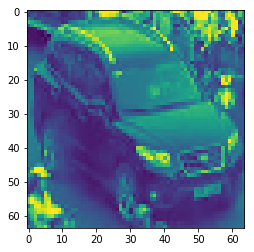

In [267]:
imgplot = plt.imshow(train_x[0])
plt.show()

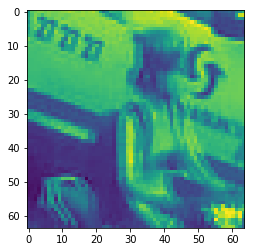

In [268]:
imgplot = plt.imshow(train_x[2399])
plt.show()

## Chuẩn hóa dữ liệu ảnh
Như đã kể trên, ảnh đầu vào có giá trị từ 0 đến 255. Nếu ta đưa trực tiếp bộ ảnh vào quá trình huấn luyện sẽ làm cho gradient lớn. Vì vậy, trước khi huấn luyện, ta có thể sử dụng phương pháp chuẩn hóa dữ liệu để đưa trung bình (mean) của tập train về 0 và độ lệch chuẩn (standard deviation - std) của nó về 1.

Đối với việc xử lý hình ảnh, ta có hai cách chuẩn hóa khác nhau:
*   (a) Xem mỗi pixel trong ảnh là một đặc trưng riêng rẽ. Ví dụ, pixel [1, 3] và pixel [4, 2] là hai đặc trưng khác nhau, được tính mean và std riêng.
*   (b) Xem các pixel khác nhau trong ảnh là cùng 1 loại đặc trưng. Lúc này, pixel [1, 3] và pixel [4, 2] được xem là cùng 1 loại đặc trưng, được tính mean và std chung.

Trong mục này, bạn cần hiện thực cách chuẩn hóa (a) trong hàm ```normalize_per_pixel``` và cách (b) trong hàm ```normalize_all_pixel```. Giả sử ta có ```m``` ảnh train ```x_0..xm−1```, mỗi ảnh train có R hàng và C cột, thì mean và std tính theo cách (a) sẽ là:

\begin{equation}
\overline{x}_{rc}=\frac{1}{m}\sum_{i=0}^{m-1}x_{rc}^{(i)}, 0 \le r \le R-1,0 \le c \le C-1 \tag{1}
\end{equation}

\begin{equation}
\sigma_{rc}=\sqrt{\frac{1}{m}\sum_{i=0}^{m-1}{(x_{rc}^{(i)}-\overline{x}_{rc})^2}} \tag{2}
\end{equation}

Đối với cách (b) ta sẽ có:

\begin{equation}
\overline{x} = \frac{1}{mRC}\sum_{i=0}^{m-1}{\sum_{r=0}^{R-1}{\sum_{c=0}^{C-1}{x_{rc}^{(i)}}}} \tag{3}
\end{equation}

\begin{equation}
\sigma=\sqrt{\frac{1}{mRC}\sum_{i=0}^{m-1}{\sum_{r=0}^{R-1}{\sum_{c=0}^{C-1}{(x_{rc}^{(i)}-\overline{x})^2}}}} \tag{4}
\end{equation}

Sau khi có được mean và std trên toàn bộ data huấn luyện, ta chuẩn hóa các mẫu trong tập huấn luyện theo cách sau:

\begin{equation}
x^{(i)} = \frac{x^{(i)}-\overline{x}}{\sigma} \tag{5}
\end{equation} 

Đối với cách (a), việc này sẽ được áp dụng riêng cho từng pixel trong số $R\times{C}$. Với cách (b), thì ta dùng chung $\overline{x}$ và $\sigma$ trong công thức (3) và (4) cho toàn bộ tất cả các pixel.

Cần lưu ý rằng $\overline{x}$ và $\sigma$ chỉ được tính trên $m$ mẫu dữ liệu huấn luyện. Sau đó, hai giá trị này sẽ được dùng lại để chuẩn hóa các mẫu dữ liệu test (và validation nếu có). Việc tính $\overline{x}$ và $\sigma$ mà có sử dụng các dữ liệu trong tập test là vi phạm nguyên tắc đánh giá các mô hình học máy. 



#### TODO 1: normalize_per_pixel 

In [0]:
# GRADED FUNCTION: normalize_per_pixel
def normalize_per_pixel(train_x, test_x):
    """normalize_per_pixel
    This function computes the mean and standard deviation of the pixels located at the same coordinates across and training images
    and performs data scaling on train_x and test_x using these computed values.

    :param train_x: training images, shape=(num_train, image_height, image_width)
    :param test_x: test images, shape=(num_test, image_height, image_width)
    """
    # The shape of train_mean and train_std should be (1, image_height, image_width)
    ### START CODE HERE ### (≈4 lines)        
    
    num, img_height, img_width = train_x.shape
    train_mean = train_x.reshape((num, -1)).mean(axis=0).reshape(1, img_height, img_width)
    train_std = train_x.reshape((num, -1)).std(axis=0).reshape(1, img_height, img_width)
    
    train_x = np.divide(np.subtract(train_x, train_mean), train_std)
    test_x = np.divide(np.subtract(test_x, train_mean), train_std)
    
    ### END CODE HERE ###
    
    return train_x, test_x

### SANITY CHECK
train_x = np.arange(2*2*3).reshape(2,2,3)
assert np.sum(normalize_per_pixel(train_x, train_x)) == 0, "Wrong"

#### TODO 2: normalize_all_pixel

In [0]:
# GRADED FUNCTION: normalize_per_pixel
def normalize_all_pixels(train_x, test_x):
    """normalize_all_pixels
    This function computes train mean and standard deviation of all pixels and performs data scaling on train_x and test_x using these computed values.

    :param train_x: training images, shape=(num_train, image_height, image_width)
    :param test_x: test images, shape=(num_test, image_height, image_width)
    """
    # The shape of train_mean and train_std should be (1, 1, 1).
    ### START CODE HERE ### (≈4 lines)
    
    train_mean = train_x.mean().reshape(1, 1, 1)
    train_std = train_x.std().reshape(1, 1, 1)
    
    train_x = np.divide(np.subtract(train_x, train_mean), train_std)
    test_x = np.divide(np.subtract(test_x, train_mean), train_std)
    ### END CODE HERE ###
    
    return train_x, test_x

### SANITY CHECK
train_x = np.arange(2*2*3).reshape(2,2,3)
assert np.sum(normalize_all_pixels(train_x, train_x)) > 0, "Wrong"

## Duỗi dữ liệu

Dữ liệu ở bước trên vẫn còn ở dạng tensor 3D ($2400 \times 64 \times 64$). Để có thể thực hiện các phép nhân ma trận trong bài toán logistic regression, ta cần chuẩn chúng về dạng tensor 2D ($2400 \times 4096$). Các bạn cần thực hiện bước này trong hàm `reshape2D`.

#### TODO 3: reshape2D

In [0]:
# GRADED FUNCTION: reshape2D
def reshape2D(tensor):
    """reshape_2D
    Reshape our 3D tensors to 2D. A 3D tensor of shape (num_samples, image_height, image_width) must be reshaped into (num_samples, image_height*image_width).
    """
    result = None
    ### START CODE HERE ### (≈1 line)
    
    result = tensor.reshape(tensor.shape[0], tensor.shape[1] * tensor.shape[2])
    ### END CODE HERE ###
    return result

### SANITY CHECK
tensor = np.arange(2*3*4).reshape(2,3,4)
assert sum(reshape2D(tensor).shape)==14, "Wrong"

## Thêm đặc trưng 1 vào dữ liệu
Để tính tích vô hướng dễ dàng, nối thêm một cột có giá trị bằng 1 vào `train_x` và `test_x` (concatenate có axis=1). Trong file có sẵn hàm `add_one` và ta nên thực hiện code trong hàm này. Sau bước này, dữ liệu huấn luyện sẽ có kích thước $2400 \times 4097$.

#### TODO 4: add_one

In [0]:
# GRADED FUNCTION: add_one
def add_one(x):
    """add_one
    This function add ones as an additional feature for x.

    :param x: input data
    """
    ### START CODE HERE ### (≈1 line)
    
    x = np.concatenate((x, np.ones(x.shape[0]).reshape(-1,1)), axis=1) 
    ### END CODE HERE ###
    return x

### SANITY CHECK
x = np.arange(2*3).reshape(2,3)
assert add_one(x).sum() == 17, "Wrong"

## Class LogisticClassifier

Nhằm hỗ trợ cho việc lập trình, đội ngũ TA cung cấp sẵn cho các bạn class **LogisticClassifier**. Một trong các thành phần chính của class LogisticClassifier là `w`, tham số mà ta cần tìm khi huấn luyện. Tham số này là một mảng có số hàng bằng số đặc trưng của dữ liệu đầu vào, số cột bằng 1. Cụ thể trong bài toán phân loại ảnh xe này, `w` sẽ là một ma trận $4097\times{1}$. `w` được khởi tạo ngẫu nhiên trong hàm `__init__(w_shape)`. Để truy xuất `w` từ bên trong class, ta dùng `self.w`, ví dụ:
```python
class logistic_classifier(object):
    def feed_forward(self, x):
        print(self.w)
```

Để truy xuất w từ bên ngoài class, ta cần có một thực thể của class và gọi thông qua thực thể này, ví dụ:
```python
if __name__ == "__main__":
    num_feature = train_x.shape[1]
    bin_classifier = LogisticClassifier((num_feature, 1))
    print(bin_classifier.w)
```

Đối với các hàm thuộc class **LogisticClassifier**, việc truy xuất cũng hoàn toàn giống với `w`. Chúng sẽ được mô tả chi tiết trong mục tiếp theo.

In [0]:
# GRADED FUNCTION
class LogisticClassifier(object):
    def __init__(self, w_shape):
        """__init__
        
        :param w_shape: create w with shape w_shape using normal distribution
        """

        mean = 0
        std = 1
        self.w = np.random.normal(0, np.sqrt(2./np.sum(w_shape)), w_shape)


    def feed_forward(self, x):
        """TODO 5: feed_forward
        This function computes the output of your logistic classification model.
        
        :param x: input
        """
        result = None
        
        ### START CODE HERE ### (≈2 lines)
        y_hat = np.matmul(x, self.w)
        result = 1 / (1 + exp(-y_hat))
        
        ### END CODE HERE ###
        
        return result


    def compute_loss(self, y, y_hat):
        """TODO 6: compute_loss
        Compute the loss using y (label) and y_hat (predicted class).

        :param y:  the label, the actual class of the sample
        :param y_hat: the probabilities that the given sample belong to class 1
        """
        loss = 0
        
        ### START CODE HERE ### (≈2 lines)
        loss = -(y*log(y_hat) + (1-y)*log(1-y_hat)).mean()

        ### END CODE HERE ###
        
        return loss


    def get_grad(self, x, y, y_hat):
        """TODO 7: get_grad
        Compute and return the gradient of w.

        :param x: input
        :param y: the label, the actual class of the sample data
        :param y_hat: predicted y
        """ 
        w_grad = None
        
        ### START CODE HERE ### (≈2 lines)
        
        w_grad = np.matmul(x.T, np.subtract(y_hat, y)) / x.shape[0]

        ### END CODE HERE ###
        
        return w_grad


    def update_weight(self, grad, learning_rate):
        """TODO 8: update_weight
        Update w using the computed gradient.

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        """
        ### START CODE HERE ### (≈1 line)

        self.w = self.w - learning_rate * grad
        ### END CODE HERE ###
        return self.w


    def update_weight_momentum(self, grad, learning_rate, momentum, momentum_rate):
        """TODO 9: update_weight using momentum
        BONUS:[YC1.8]
        Update w using the algorithm with momentum

        :param grad: gradient computed from the loss
        :param learning_rate: float, learning rate
        :param momentum: the array storing momentum for training w, should have the same shape as that of w
        :param momentum_rate: float, how much momentum to reuse after each loop (denoted as gamma in the following section)
        """
        ### START CODE HERE ### (≈3 lines)

        momentum = momentum * momentum_rate + learning_rate * grad
        self.w = self.w - momentum
        ### END CODE HERE ###
        return self.w


    def numerical_check(self, x, y, grad):
        eps = 0.000005
        w_test0 = np.copy(self.w)
        w_test1 = np.copy(self.w)
        w_test0[2] = w_test0[2] - eps
        w_test1[2] = w_test1[2] + eps

        y_hat0 = np.dot(x, w_test0)
        y_hat0 = 1. / (1. + np.exp(-y_hat0))
        loss0 = self.compute_loss(y, y_hat0) 

        y_hat1 = np.dot(x, w_test1)
        y_hat1 = 1. / (1. + np.exp(-y_hat1))
        loss1 = self.compute_loss(y, y_hat1) 

        numerical_grad = (loss1 - loss0)/(2*eps)
        print(numerical_grad)
        print(grad[2])

### SANITY CHECK        
eps = 0.001        
classifer = LogisticClassifier((3,1))
classifer.w = np.arange(3*1).reshape(3,1)
x = np.ones(2*3).reshape(2,3)
y = 1
y_hat = classifer.feed_forward(x)
assert abs(sum(y_hat) - 1.905) < eps, "Wrong"
loss = classifer.compute_loss(y, y_hat)
assert abs(loss - 0.048) < eps, "Wrong"
grad = classifer.get_grad(x, y, y_hat)
assert abs(sum(grad) + 0.142) < eps, "Wrong"
updateweight = classifer.update_weight(grad, 0.1)
assert abs(sum(updateweight) - 3.014) < eps, "Wrong"
updatemomen = classifer.update_weight_momentum(grad, 0.1, 0.1, 0.1)
assert abs(sum(updatemomen) - 2.998) < eps, "Wrong"

## Tính các giá trị phân loại

Các giá trị phân loại, $\hat{y}$, sẽ được tính trong hàm `feed_forward` của class `LogisticClassifier`. Công thức tính như sau:

\begin{equation}
z = xw  \tag{6}
\end{equation}
\begin{equation}
\hat{y} = \frac{1}{1+e^{-z}} \tag{7}
\end{equation}

Ở đây, $w = [w_0, w_1,.., w_{4096}]^T$ là các tham số cần học (lưu trong biến `self.w` trong class `LogisticClassifier`). Lẽ ra công thức (6) được viết là $z=xw+w_{4096}$, tuy nhiên ở bước trên ta đã thêm 1 vào làm đặc trưng cuối cho tất cả các mẫu. Việc này giúp cho quá trình nhân ma trận và quản lý các biến gọn hơn.

#### TODO 5: feed_forward

Các bạn làm bài vào phần class [ở trên](https://colab.research.google.com/drive/1sQr0G0ed6zTWzGNWV5JoHkkdXxr74_VN?authuser=1#scrollTo=-HvKyAwnteLa).

## Tính độ lỗi

Việc tính độ lỗi được thực hiện trong hàm `compute_loss` của class `LogisticClassifier`. Công thức tính độ lỗi như sau:

\begin{equation}
J(w) = -\frac{1}{m}\sum_{i=0}^{m-1}(y^{(i)}\log{\hat{y}^{(i)}} + (1-y^{(i)})\log(1-\hat{y}^{(i)})) \tag{8}
\end{equation}

Trong đó:
-  $y^{(i)}$ là nhãn của mẫu thứ $i$, mẫu thuộc lớp 0 sẽ có $y^{(i)}=0$, mẫu thuộc lớp 1 sẽ có $y^{(i)}=1$. Ta có thể truy cập các nhãn này thông qua biến `train_y` và `test_y`.
- $\hat{y}^{(i)} \in (0, 1)$ là phần tử thứ $i$ trong vector $\hat{y}$.
- $m=2400$ là tổng số mẫu huấn luyện.


Để tính trung bình trên ma trận theo hàng hoặc cột, ta có thể sử dụng hàm `np.mean()` với tham số axis tương ứng.

#### TODO 6: compute_loss

Các bạn làm bài vào phần class [ở trên](https://colab.research.google.com/drive/1sQr0G0ed6zTWzGNWV5JoHkkdXxr74_VN?authuser=1#scrollTo=-HvKyAwnteLa).

## Tính đạo hàm
Để tính đạo hàm riêng cho thành phần $w_j$ trong $w$ trong hàm `get_grad`, ta dùng công thức sau:
\begin{equation}
\frac{\partial  J(w_j)}{\partial w_j} = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}^{(i)} - y^{(i)})x^{(i)}_j \tag{9}
\end{equation}

Trong trường hợp này, sau khi thêm 1 vào `train_x` thì ta sẽ có $0 \le j \le 4096$.

#### TODO 7: get_grad
Các bạn làm bài vào phần class [ở trên](https://colab.research.google.com/drive/1sQr0G0ed6zTWzGNWV5JoHkkdXxr74_VN?authuser=1#scrollTo=-HvKyAwnteLa).

## Cập nhật $w$
Để huấn luyện được mô hình phân loại trong hàm `update_weight`, ta cần cập nhật $w$ theo công thức sau:
\begin{equation}
w = w - \alpha\times\frac{\partial  J(w)}{\partial w} \tag{10}
\end{equation}

Với $\alpha$ là hệ số học (`learning_rate`).

#### TODO 8: update_weight
Các bạn làm bài vào phần class [ở trên](https://colab.research.google.com/drive/1sQr0G0ed6zTWzGNWV5JoHkkdXxr74_VN?authuser=1#scrollTo=-HvKyAwnteLa).

## Cập nhật $w$ dùng momentum

Giải thuật cập nhật trình bày trong phần trước có điểm yếu là chậm và dễ rơi vào tối ưu cục bộ. Tuy trong bài này, giải thuật đó cũng đủ để giải quyết, nhưng ta vẫn có thể sử dụng giải thuật có quán tính để việc huấn luyện diễn ra nhanh hơn.

Khởi tạo ma trận quán tính trước khi vào vòng lặp chính:
\begin{equation}
\Delta w = 0 \tag{11}
\end{equation}

Ở đây, $\Delta w$ là ma trận có kích thước bằng chính kích thước của $w$. Quá trình cập nhật $w$ sẽ được diễn ra như sau:
\begin{equation}
\Delta w = \gamma\Delta w + \alpha\frac{\partial  J(w)}{\partial w} \tag{12}
\end{equation}

\begin{equation}
w = w - \Delta w \tag{13}
\end{equation}

Với $\gamma$ là hệ số quán tính (thường được đặt là 0.9).

#### TODO 9: update_weight_momentum

Các bạn làm bài vào phần class [ở trên](https://colab.research.google.com/drive/1sQr0G0ed6zTWzGNWV5JoHkkdXxr74_VN?authuser=1#scrollTo=-HvKyAwnteLa).

## Đánh giá mô hình phân loại
Để đánh giá mô hình phân loại trên tập kiểm thử (`test_x` và `test_y`), trước tiên, ta cần thực hiện tính các giá trị phân loại trên`test_x`. Sau khi đã có các giá trị này, ta sử dụng các tiêu chí sau để đánh giá mô hình:

\begin{equation}
Precision = \frac{TP}{TP+FP} \tag{14}
\end{equation}

\begin{equation}
Recall = \frac{TP}{P} \tag{15}
\end{equation}

\begin{equation}
F_1-score = 2\times\frac{Precision\times Recall}{Precision+Recall} \tag{16}
\end{equation}

Trong đó:
- Lớp positive là lớp có giá trị y = 1.
- TP (true positive) là tổng số các mẫu mà mô hình dự đoán là positive. ($\hat{y}=1$) và thực sự có nhãn là positive ($y=1$).
- FP (false positive) là tổng số các mẫu mô hình dự đoán là positive($\hat{y}=1$) nhưng thực chất có nhãn là negative ($y=0$).
- P là tổng số mẫu positive trong tập test.

Nhiệm vụ của bạn trong bước này là tính các thông số trên trong hàm `test`. Khi tiến hành kiểm thử, người ra đề đã tính được các giá trị $Precision=0.766$, $Recall=0.830$ và $F_1-score=0.797$. Bạn hãy cố gắng hoàn thiện bài làm của mình để đạt kết quả tương tự hoặc tốt hơn.

#### TODO 10: test

In [0]:
# GRADED FUNCTION
def test(y_hat, test_y, thres=0.5):
    """test
    Compute precision, recall and F1-score based on predicted test values

    :param y_hat: predicted values, output of classifier.feed_forward
    :param test_y: test labels
    """
    
    # [TODO 1.10]
    # Compute test scores using test_y and y_hat

    precision = 0
    recall = 0
    f1 = 0
    ### START CODE HERE ### (≈7 lines)

    TP = len(np.where((test_y - y_hat > 0) & (test_y - y_hat < 0.5))[0])
    FP = len(np.where(test_y - y_hat < -0.5)[0])
    P = len(np.where(test_y == 1)[0])
 
    precision = TP / (TP + FP)
    recall = TP / P
    f1 = 2 * precision * recall / (precision + recall)
    
    ### END CODE HERE ###

    return precision, recall, f1

### SANITY CHECK
y_hat = np.array([0.4, 0.7, 0.8, 0.3, 0.2])
test_y = np.array([0, 1, 1, 0, 0])
assert sum(test(y_hat, test_y)) == 3, "Wrong"

## Vòng lặp huấn luyện

Vòng lặp của quá trình huấn luyện được xây dựng trong đoạn code sau đây. Tất cả khung sườn cho việc thực thi đã được lập trình sẵn. Ta có thể thay đổi hai tham số tác động đến quá trình huấn luyện như sau:

- `num_epoch`: số lượng vòng lặp cho quá trình huấn luyện.
- `learning_rate`: hệ số học $\alpha$.
- `momentum_rate`: hệ số momentum $\gamma$.
- `epochs_to_draw`: số lượng epochs cần đạt được để vẽ đồ thị độ lỗi trong lúc huấn luyện.

In [0]:
def plot_loss(all_loss):
    plt.figure(1)
    plt.clf()
    plt.plot(all_loss)

Reading vehicle data...
EOF Reached
Done reading


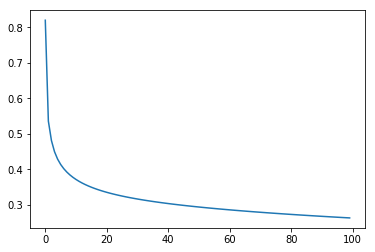

Epoch 100: loss is 0.26371


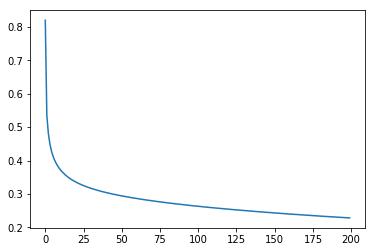

Epoch 200: loss is 0.22853


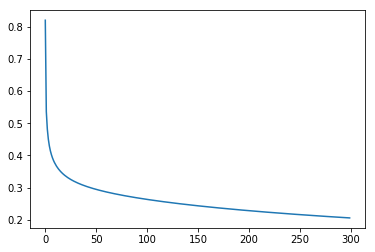

Epoch 300: loss is 0.20576


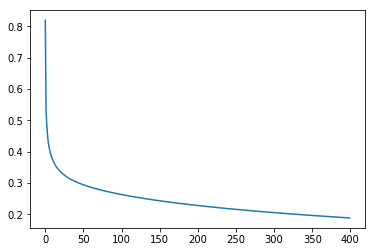

Epoch 400: loss is 0.18873


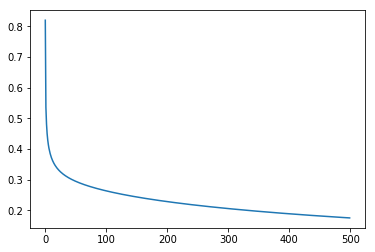

Epoch 500: loss is 0.17513


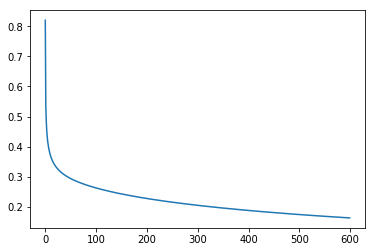

Epoch 600: loss is 0.16386


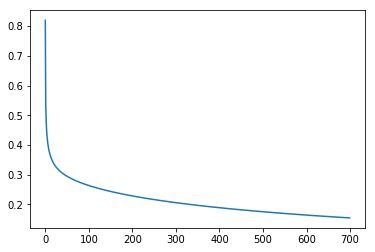

Epoch 700: loss is 0.15427


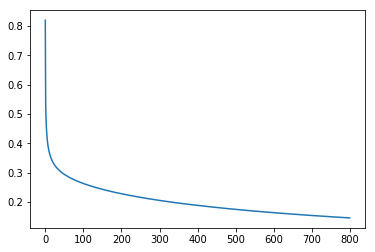

Epoch 800: loss is 0.14596


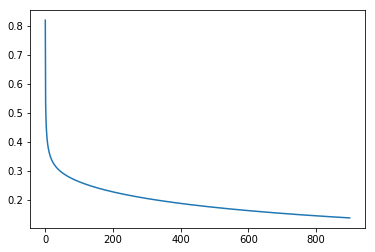

Epoch 900: loss is 0.13867


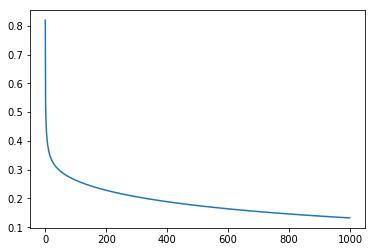

Epoch 1000: loss is 0.13219
Precision: 0.766
Recall: 0.830
F1-score: 0.797


In [276]:
#@title Training { display-mode: "both" }
normalize_method = "per_pixel" #@param ["all_pixels", "per_pixel"]
update_weight_method = "normal" #@param ["normal", "momentum"]
num_epoch = 1000 #@param {type:"integer"}
learning_rate = 0.01 #@param {type:"number"}
momentum_rate = 0.9 #@param {type:"number"}
epochs_to_draw = 100 #@param {type:"integer"}

np.random.seed(2018)

# Load data from file
# Make sure that vehicles.dat is in data/
train_x, train_y, test_x, test_y = get_vehicle_data()
num_train = train_x.shape[0]
num_test = test_x.shape[0]

# Normalize our data: choose one of the two methods before training
if normalize_method == "all_pixels":
    train_x, test_x = normalize_all_pixels(train_x, test_x) 
else:
    train_x, test_x = normalize_per_pixel(train_x, test_x) 

# Reshape our data
# train_x: shape=(2400, 64, 64) -> shape=(2400, 64*64)
# test_x: shape=(600, 64, 64) -> shape=(600, 64*64)
train_x = reshape2D(train_x)
test_x = reshape2D(test_x)

# Pad 1 as the last feature of train_x and test_x
train_x = add_one(train_x) 
test_x = add_one(test_x)

# Create classifier
num_feature = train_x.shape[1]
bin_classifier = LogisticClassifier((num_feature, 1))
momentum = np.zeros_like(bin_classifier.w)

# Define hyper-parameters and train-related parameters
all_loss = []
plt.ion()
for e in range(num_epoch):    
    y_hat = bin_classifier.feed_forward(train_x)
    loss = bin_classifier.compute_loss(train_y, y_hat)
    grad = bin_classifier.get_grad(train_x, train_y, y_hat)

    # Updating weight: choose either normal SGD or SGD with momentum
    if update_weight_method == "normal":
        bin_classifier.update_weight(grad, learning_rate)
    else: 
        bin_classifier.update_weight_momentum(grad, learning_rate, momentum, momentum_rate)

    all_loss.append(loss) 

    if (e % epochs_to_draw == epochs_to_draw-1):
        plot_loss(all_loss)
        plt.show()
        plt.pause(0.1)     
        print("Epoch %d: loss is %.5f" % (e+1, loss))

y_hat = bin_classifier.feed_forward(test_x)
precision, recall, f1 = test(y_hat, test_y)
print("Precision: %.3f" % precision)
print("Recall: %.3f" % recall)
print("F1-score: %.3f" % f1)

## Định Nghĩa Lớp LogisticRegressionTF

Chúng ta sử dụng tensorflow eager execution để cài đặt mô hình logistic regression. Với tf eager execution, giá trị của các biến được tính toán ngay lập tức thay vì xây dựng computational graph để chạy sau đó. Một trong những lợi ích thiết thực nhất là giúp chúng ta dễ dàng debug mô hình, xây dựng được dynamic model.

Để xây dựng mô hình bằng eager execution, chúng ta thường định nghĩa một lớp đối tượng như mình họa ở dưới.

Chúng ta kế thừa lớp Model và cài đặt 2 hàm chính:
- init: khởi tạo tất cả các tham số. 
- call: hàm dùng cho feedforward.

In [0]:
class LogisticRegressionTF(tf.keras.Model):

    def __init__(self, num_class):
        super(LogisticRegressionTF, self).__init__()
        # init all weights here
        self.dense = tf.keras.layers.Dense(num_class)

    def call(self, inputs, training=None, mask=None):
        output = self.dense(inputs)
        
        # softmax op does not exist on the gpu
        with tf.device('/cpu:0'):
            output = tf.nn.softmax(output)        
        return output


#### TODO 11: Định nghĩa one hot encoder

In [0]:
# GRADED FUNCTION: create_one_hot
def create_one_hot(labels, num_k=10):
    """create_one_hot
    This function creates a one-hot (one-of-k) matrix based on the given labels.

    :param labels: list of labels, each label is one of 0, 1, 2,... , num_k - 1
    :param num_k: number of classes we want to classify
    """
    eye_mat = None
    ### START CODE HERE ### (≈2 lines)
    eye_mat = np.eye(num_k)[labels]
    
    ### END CODE HERE ###
    return eye_mat

### SANITY CHECK
x = [1, 2, 3]
y = create_one_hot(x, 4)
assert y.shape == (3,4), "Wrong"
assert sum(np.argmax(y, axis=0)) == 3, "Wrong"

### Huấn luyện mô hình với tensorflow

In [292]:
#@title Training { display-mode: "both" }
normalize_method = "all_pixels" #@param ["all_pixels", "per_pixel"]
num_epoch = 10 #@param {type:"integer"}
learning_rate = 0.001 #@param {type:"number"}
batch_size = 32
num_classes = 2
np.random.seed(2018)
tf.set_random_seed(2018)

# Load data from file
# Make sure that vehicles.dat is in data/
train_x, train_y, test_x, test_y = get_vehicle_data()
num_train = train_x.shape[0]
num_test = test_x.shape[0]  

#generate_unit_testcase(train_x.copy(), train_y.copy()) 
#logistic_unit_test()

# Normalize our data: choose one of the two methods before training
if normalize_method == "all_pixels":
    train_x, test_x = normalize_all_pixels(train_x, test_x) 
else:
    train_x, test_x = normalize_per_pixel(train_x, test_x) 

# Reshape our data
# train_x: shape=(2400, 64, 64) -> shape=(2400, 64*64)
# test_x: shape=(600, 64, 64) -> shape=(600, 64*64)
train_x = reshape2D(train_x)
test_x = reshape2D(test_x)
train_y = create_one_hot(train_y.astype('int32').flatten().tolist(), num_k=2)
test_y = create_one_hot(test_y.astype('int32').flatten().tolist(), num_k=2)

device = '/cpu:0' if tfe.num_gpus() == 0 else '/gpu:0'

with tf.device(device):
    # build model and optimizer
    model = LogisticRegressionTF(num_classes)
    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    

    # train
    model.fit(train_x, train_y, batch_size=batch_size, epochs=num_epoch,
              validation_data=(test_x, test_y), verbose=2)

    # evaluate on test set
    scores = model.evaluate(test_x, test_y, 32, verbose=2)
    
    y_hat = model.predict(test_x)
    precision, recall, f1 = test(y_hat, test_y)
    print("Precision: %.3f" % precision)
    print("Recall: %.3f" % recall)
    print("F1-score: %.3f" % f1)

Reading vehicle data...
EOF Reached
Done reading
Train on 2400 samples, validate on 600 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
2400/2400 - 1s - loss: 0.5118 - acc: 0.8083 - val_loss: 0.5372 - val_acc: 0.7667
Epoch 2/10
2400/2400 - 0s - loss: 0.3263 - acc: 0.8704 - val_loss: 0.5589 - val_acc: 0.7617
Epoch 3/10
2400/2400 - 0s - loss: 0.2680 - acc: 0.8896 - val_loss: 0.6135 - val_acc: 0.7717
Epoch 4/10
2400/2400 - 0s - loss: 0.2571 - acc: 0.8946 - val_loss: 0.5826 - val_acc: 0.7683
Epoch 5/10
2400/2400 - 0s - loss: 0.2282 - acc: 0.9079 - val_loss: 0.6472 - val_acc: 0.7467
Epoch 6/10
2400/2400 - 0s - loss: 0.2039 - acc: 0.9167 - val_loss: 0.6398 - val_acc: 0.7533
Epoch 7/10
2400/2400 - 0s - loss: 0.1685 - acc: 0.9346 - val_loss: 0.6482 - val_acc: 0.7617
Epoch 8/10
2400/2400 - 0s - loss: 0.1547 - acc: 0.9429 - val_loss: 0.6945 - val_acc: 0.7450
Epoch 9/10
2400/2400 - 0s - loss: 0.1502 - acc: 0.9429 - val_loss: 0.7095 

# Bài 2: Phân loại mười lớp

## Dữ liệu fashion MNIST

Ta có thể đọc tập dữ liệu này bằng hàm `get_mnist_data()`:

In [302]:
train_x, train_y, val_x, val_y, test_x, test_y = get_mnist_data()

Reading fashion MNIST data...


Tập dữ liệu này gồm các ảnh xám kích thước $28 \times 28$. Có tất cả 50000 ảnh train, 10000 ảnh validation và 10000 ảnh test. Mỗi ảnh thuộc một trong 10 loại quần, áo, giày, túi xách, v.v. Tuy nhiên trong bài tập này ta chỉ lấy 2500 ảnh train, 500 ảnh validation và 500 ảnh test.


In [303]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(2500, 784)
(2500,)
(500, 784)
(500,)
(500, 784)
(500,)


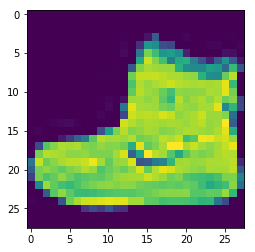

In [304]:
imgplot = plt.imshow(train_x[0].reshape(28,28))
plt.show()

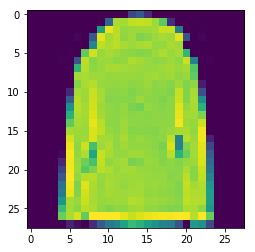

In [305]:
imgplot = plt.imshow(train_x[100].reshape(28,28))
plt.show()

Lưu ý là giá trị của `train_y` và `test_y` sẽ có thể là 0, 1, ..., 9 thay vì 0 và 1 như bài 1. Ngoài ra, dữ liệu này khi được đọc lên đã có dạng tensor 2D ($3500 \times 784$).

## Chuẩn hóa dữ liệu
Trong bước này, ta sẽ chuẩn hóa dữ liệu `train_x`, `val_x` và `test_x` theo cách (b) đã đề cập trong phần trước. Tuy nhiên, do tập dữ liệu MNIST khi load đã được đặt dưới dạng tensor 2D, nên trong công thức tính tổng chỉ còn $m$ và $R=784$.

#### TODO 12: normalize

In [0]:
# GRADED FUNCTION: normalize
def normalize(train_x, val_x, test_x):
    """normalize
    This function computes the mean and standard deviation of all pixels and performs data scaling on train_x, val_x and test_x using these computed values.
    Note that in this classification problem, the shape of the data is (num_samples, image_width * image_height).

    :param train_x: train images, shape=(num_train, image_height * image_width)
    :param val_x: validation images, shape=(num_val, image_height * image_width)
    :param test_x: test images, shape=(num_test, image_height * image_width)
    """
    # The shape of train_mean and train_std should be (1, 1)
    ### START CODE HERE ### (≈5 lines)
    train_mean = train_x.mean().reshape(1,1)
    train_std = train_x.std().reshape(1,1)
    
    train_x = (train_x - train_mean) / train_std
    val_x = (val_x - train_mean) / train_std
    test_x = (test_x - train_mean) / train_std
    ### END CODE HERE ###
    return train_x, val_x, test_x

### SANITY CHECK
train_x = np.arange(2*4).reshape(2, 4)
x, y, z = normalize(train_x, train_x, train_x)
assert np.sum((x, y, z)) == 0, "Wrong"

## Class SoftmaxClassifier

Class này kế thừa lại một số thuộc tính từ class LogisticClassifier như `__init__`, `w`. Riêng với các hàm `feed_forward`, `compute_loss` và `get_grad` ta cần phải hiện thực lại.

In [0]:
# GRADED FUNCTION
class SoftmaxClassifier(LogisticClassifier):
    def __init__(self, w_shape):
        """__init__
        
        :param w_shape: create w with shape w_shape using normal distribution
        """
        super(SoftmaxClassifier, self).__init__(w_shape)


    def softmax(self, x):
        """TODO 20: softmax

        :param x: input
        """
        result = None
        ### START CODE HERE ### (≈4 lines)
#         e_x = np.exp(x - np.max(x))
#         result = e_x / e_x.sum(axis=0)
        x -= np.max(x)
        result = (np.exp(x).T / np.sum(np.exp(x),axis=1)).T
        
        ### END CODE HERE ###
        return result


    def feed_forward(self, x):
        """TODO 19: feed_forward
        This function computes the output of your softmax regression model
        
        :param x: input
        """
        result = None
        ### START CODE HERE ### (≈2 lines)
        result = np.matmul(x, self.w)
        result = self.softmax(result)

        ### END CODE HERE ###
        return result


    def compute_loss(self, y, y_hat):
        """TODO 21: compute_loss
        Compute the loss using y (label) and y_hat (predicted class)

        :param y:  the label, the actual class of the sample data
        :param y_hat: the classifying probabilities of all sample data
        """
        loss = 0
        ### START CODE HERE ### (≈3 lines)

        loss = -np.sum(y * log(y_hat)) / len(y_hat)
        ### END CODE HERE ###
        return loss


    def get_grad(self, x, y, y_hat):
        """TODO 22: get_grad
        Compute and return the gradient of w

        :param loss: computed loss between y_hat and y in the train dataset
        :param y_hat: predicted y
        """ 
        w_grad = None
        ### START CODE HERE ### (≈2 lines)
        w_grad = np.dot(x.T,(y_hat - y)) / len(y_hat)
        ### END CODE HERE ###
        return w_grad
   

    def numerical_check(self, x, y, grad):
        i = 3
        j = 0
        eps = 0.000005
        w_test0 = np.copy(self.w)
        w_test1 = np.copy(self.w)
        w_test0[i,j] = w_test0[i,j] - eps
        w_test1[i,j] = w_test1[i,j] + eps

        y_hat0 = np.dot(x, w_test0)
        y_hat0 = self.softmax(y_hat0)
        loss0 = self.compute_loss(y, y_hat0) 

        y_hat1 = np.dot(x, w_test1)
        y_hat1 = self.softmax(y_hat1)
        loss1 = self.compute_loss(y, y_hat1) 

        numerical_grad = (loss1 - loss0)/(2*eps)
        print(numerical_grad)
        print(grad[i,j])
        
### SANITY CHECK
eps = 0.001        
classifer = SoftmaxClassifier((3,1))
classifer.w = np.arange(3*1).reshape(3,1)
x = np.ones(2*3).reshape(2,3)/2
y = 0
y_hat = classifer.feed_forward(x)
assert sum(y_hat)==2, "Wrong"
loss = classifer.compute_loss(y, y_hat)
assert loss==0, "Wrong"
grad = classifer.get_grad(x, y, y_hat)
assert sum(grad)==1.5, "Wrong"
# updateweight = classifer.update_weight(grad, 0.1)
# assert sum(updateweight) - 2.849 < eps, "Wrong"
# updatemomen = classifer.update_weight_momentum(grad, 0.1, 0.1, 0.1)
# assert sum(updatemomen) - 2.67 < eps, "Wrong"

## Tiền xử lý vector label thành dạng one-hot

Các biến `train_y`, `val_y`, `test_y` lúc này là một vector chứa các giá trị 0, 1, ..., 9; nhưng để tính hàm lỗi của softmax regression, ta nên chuyển chúng về dạng ma trận one-hot (one-of-k). Giả sử ta có vector label có 6 phần tử, mỗi phần tử nằm trong khoảng từ 0 đến 4:

\begin{equation}
	y = [3,4,0,0,2,1]^T \tag{17}
\end{equation}

Ta sẽ có biến đổi one-hot tương ứng của nó là:
\begin{equation}
y = \begin{bmatrix}
	0 & 0 & 0 & \color{red}1 & 0\\
	0 & 0 & 0 & 0 & \color{red}1\\
	\color{red}1 & 0 & 0 & 0 & 0\\
	\color{red}1 & 0 & 0 & 0 & 0\\
	0 & 0 & \color{red}1 & 0 & 0\\
	0 & \color{red}1 & 0 & 0 & 0
\end{bmatrix} \tag{18}
\end{equation}

Label thứ nhất có giá trị là 3, vì vậy nên trong hàng thứ nhất ở ma trận trên cột 3 có giá trị 1, tất cả các cột khác trong hàng này là 0. Tương tự cho hàng thứ 2, label là 4, nên cột 4 trong hàng 2 có giá trị là 1.


Để việc biến đổi giá trị của mảng sang dạng one-hot được nhanh chóng, ta nên sử dụng index array hay index vector trên ma trận đơn vị. Tham khảo thêm ở đây: [Numpy basic indexing - Index arrays](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.indexing.html#index-arrays).

## Tính các giá trị phân loại

Để tính các giá trị phân loại trong bài này, ta hiện thực các công thức sau trong hàm `feed_forward` và `softmax`:

\begin{equation}
z = xw \space, \quad x \in R^{m\times D}, w \in R^{D \times K} \tag{19}
\end{equation}

Trong đó, $m$ là số lượng mẫu dữ liệu, $D$ là số lượng đặc trưng của dữ liệu đầu vào (785 sau khi thêm 1 vào cuối), $K$ là số lượng nhãn trong bài toán ta đang làm (10).

\begin{equation}
z_{max} = [max(z^{(0)}), max(z^{(1)}),.., max(z^{(m-1)})]^T  \tag{20}
\end{equation}

Tại đây, $z_{max}$ là một vector cột (kích thước $m \times 1$).

\begin{equation}
z' = e^{z - z_{max}} \tag{21}
\end{equation}

Trong biểu thức trên, ta sẽ dùng cột thứ nhất của $z$ trừ cho $z_{max}$, cột thứ 2 của $z$ trừ cho $z_{max}$, v.v. Sau đó, ta tính lũy thừa cho từng phần tử trên hiệu đã tính. Kết quả tại bước này là một ma trận $z'$ có kích thước $m \times K$.

Kế tiếp, ta cần tính tổng sau:

\begin{equation}
s = \sum^{K-1}_{k=0}z'^{(i)}_{k} ,\quad 0\le i \le m-1\tag{22}
\end{equation}

Như vậy, $s$ sẽ là vector chứa tổng từng hàng của ma trận $z'$. $s$ có kích thước $m \times 1$. Sau cùng, ta có thể tính softmax bằng cách lấy mỗi phần tử trong $z'$ chia cho tổng hàng tương ứng:

\begin{equation}
\hat{y}^{(i)}_{k} = \frac{z'^{(i)}_{k}}{s^{(i)}}, \quad 0\le i \le m-1, 0\le k \le K-1 \tag{23}
\end{equation}

Sau khi tổng hợp lại toàn bộ các phần tử $i, k$ của $\hat{y}$, ta sẽ có ma trận có kích thước $m \times K$. Trong ma trận này, mỗi hàng thứ $i$ biểu diễn vector xác suất lớp của mẫu ảnh thứ $i$. Vì vậy, tổng của mỗi hàng luôn bằng 1.

#### TODO 13: feed_forward

Các bạn hoàn thành hàm `feed_forward` ở phần class [SoftmaxClassifier](https://colab.research.google.com/drive/1sQr0G0ed6zTWzGNWV5JoHkkdXxr74_VN?authuser=1#scrollTo=jKsh9eo5hOMq).

#### TODO 14: softmax

Các bạn hoàn thành hàm `softmax` ở phần class [SoftmaxClassifier](https://colab.research.google.com/drive/1sQr0G0ed6zTWzGNWV5JoHkkdXxr74_VN?authuser=1#scrollTo=jKsh9eo5hOMq).